**Chapter 18 – Reinforcement Learning**

Modifications made by: Humberto Alejandro Zepeda González




<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/18_reinforcement_learning.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [ ]:
import sys
import numpy as np
assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier. We will also display some Matplotlib animations, and there are several possible options to do that: we will use the Javascript option.

In [ ]:
import matplotlib.animation
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

And let's create the `images/rl` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [ ]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

Let's install the Gymnasium library, which provides many environments for Reinforcement Learning. We'll also install the extra libraries needed for classic control environments (including CartPole, which we will use shortly), as well as for Box2D and Atari environments, which are needed for the exercises.

**Important notes:**
* OpenAI has handed over the maintenance and developmnent of the Gym library to the Farama foundation (see the [announcement](https://farama.org/Announcing-The-Farama-Foundation)), and the library was renamed to Gymnasium. It's a drop-in replacement for OpenAI Gym: you can just install `gymnasium` instead of `gym`, and `import gymnasium as gym`, and everything should work fine.
* by running the following cell, you accept the Atari ROM license.

In [ ]:
if "google.colab" in sys.modules or "kaggle_secrets" in sys.modules:
    %pip install -q -U gymnasium swig
    %pip install -q -U gymnasium[classic_control,box2d,atari,accept-rom-license]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.3 MB/s eta 0:00:00


# Introduction to ~OpenAI gym~ Gymnasium

In this notebook we will be using [gymnasium](https://github.com/Farama-Foundation/Gymnasium), a great toolkit for developing and comparing Reinforcement Learning algorithms. It provides many environments for your learning *agents* to interact with. Let's import Gym and make a new CartPole environment:

In [ ]:
import gymnasium as gym

env = gym.make("CartPole-v1", render_mode="rgb_array")

The CartPole (version 1) is a very simple environment composed of a cart that can move left or right, and pole placed vertically on top of it. The agent must move the cart left or right to keep the pole upright.

Let's initialize the environment by calling is `reset()` method. This returns an observation, as well as a dictionary that may contain extra information. Both are environment-specific.

In [ ]:
obs, info = env.reset(seed=42)
obs

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

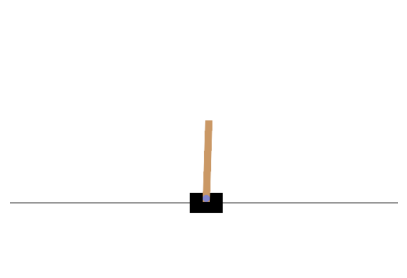

In [ ]:
# extra code – creates a little function to render and plot an environment

def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

plot_environment(env)
plt.show()

Let's see how to interact with an environment. Your agent will need to select an action from an "action space" (the set of possible actions). Let's see what this environment's action space looks like:

# A simple hard-coded policy

Let's hard code a simple strategy: if the pole is tilting to the left, then push the cart to the left, and _vice versa_. Let's see if that works:

In [ ]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)



In [ ]:

np.mean(totals), np.std(totals), min(totals), max(totals)

(41.698, 8.389445512070509, 24.0, 63.0)

Well, as expected, this strategy is a bit too basic: the best it did was to keep the poll up for only 63 steps. This environment is considered solved when the agent keeps the poll up for 200 steps.

Let's visualize one episode. You can learn more about Matplotlib animations in the [Matplotlib tutorial notebook](tools_matplotlib.ipynb#Animations).

In [ ]:
# extra code – this cell displays an animation of one episode

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)



##### Hard coded rendered

In [ ]:
show_one_episode(basic_policy)

Clearly the system is unstable and after just a few wobbles, the pole ends up too tilted: game over. We will need to be smarter than that!

# Neural Network Policies

Let's create a neural network that will take observations as inputs, and output the probabilities of actions to take for each observation. To choose an action, the network will estimate a probability for each action, then we will select an action randomly according to the estimated probabilities. In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron: it will output the probability `p` of the action 0 (left), and of course the probability of action 1 (right) will be `1 - p`.

In [ ]:

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In this particular environment, the past actions and observations can safely be ignored, since each observation contains the environment's full state. If there were some hidden state then you may need to consider past actions and observations in order to try to infer the hidden state of the environment. For example, if the environment only revealed the position of the cart but not its velocity, you would have to consider not only the current observation but also the previous observation in order to estimate the current velocity. Another example is if the observations are noisy: you may want to use the past few observations to estimate the most likely current state. Our problem is thus as simple as can be: the current observation is noise-free and contains the environment's full state.

You may wonder why we plan to pick a random action based on the probability given by the policy network, rather than just picking the action with the highest probability. This approach lets the agent find the right balance between _exploring_ new actions and _exploiting_ the actions that are known to work well. Here's an analogy: suppose you go to a restaurant for the first time, and all the dishes look equally appealing so you randomly pick one. If it turns out to be good, you can increase the probability to order it next time, but you shouldn't increase that probability to 100%, or else you will never try out the other dishes, some of which may be even better than the one you tried.

Let's write a small policy function that will use the neural net to get the probability of moving left, then let's use it to run one episode:

#### NN (not trained) stochastic policy rendered

In [ ]:
# extra code – a function that creates an animation for a given policy model

def pg_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(pg_policy)

Yeah... pretty bad. The neural network will have to learn to do better. First let's see if it is capable of learning the basic policy we used earlier: go left if the pole is tilting left, and go right if it is tilting right.

Let's see if it can learn a better policy on its own. One that does not wobble as much.

Testing pf the neural networ stochastic policy

In [ ]:
pgstototals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = pg_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)



KeyboardInterrupt: 

In [ ]:
np.mean(pgstototals), np.std(pgstototals), min(pgstototals), max(pgstototals)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: min() arg is an empty sequence

# Policy Gradients

To train this neural network we will need to define the target probabilities **y**. If an action is good we should increase its probability, and conversely if it is bad we should reduce it. But how do we know whether an action is good or bad? The problem is that most actions have delayed effects, so when you win or lose points in an episode, it is not clear which actions contributed to this result: was it just the last action? Or the last 10? Or just one action 50 steps earlier? This is called the _credit assignment problem_.

The _Policy Gradients_ algorithm tackles this problem by first playing multiple episodes, then making the actions near positive rewards slightly more likely, while actions near negative rewards are made slightly less likely. First we play, then we go back and think about what we did.

Let's start by creating a function to play a single step using the model. We will also pretend for now that whatever action it takes is the right one, so we can compute the loss and its gradients. We will just save these gradients for now, and modify them later depending on how good or bad the action turned out to be.

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

If `left_proba` is high, then `action` will most likely be `False` (since a random number uniformally sampled between 0 and 1 will probably not be greater than `left_proba`). And `False` means 0 when you cast it to a number, so `y_target` would be equal to 1 - 0 = 1. In other words, we set the target to 1, meaning we pretend that the probability of going left should have been 100% (so we took the right action).

Now let's create another function that will rely on the `play_one_step()` function to play multiple episodes, returning all the rewards and gradients, for each episode and each step:

In [ ]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

The Policy Gradients algorithm uses the model to play the episode several times (e.g., 10 times), then it goes back and looks at all the rewards, discounts them and normalizes them. So let's create couple functions for that: the first will compute discounted rewards; the second will normalize the discounted rewards across many episodes.

In [ ]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

Say there were 3 actions, and after each action there was a reward: first 10, then 0, then -50. If we use a discount factor of 80%, then the 3rd action will get -50 (full credit for the last reward), but the 2nd action will only get -40 (80% credit for the last reward), and the 1st action will get 80% of -40 (-32) plus full credit for the first reward (+10), which leads to a discounted reward of -22:

In [ ]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

To normalize all discounted rewards across all episodes, we compute the mean and standard deviation of all the discounted rewards, and we subtract the mean from each discounted reward, and divide by the standard deviation:

In [ ]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [ ]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [ ]:
# extra code – let's create the neural net and reset the environment, for
#              reproducibility

tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

obs, info = env.reset(seed=42)

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [ ]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # extra code – displays some debug info during training
    total_rewards = np.array([sum(reward) for reward in all_rewards])


    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py:291: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return int(self._numpy())


In [ ]:
np.mean(total_rewards), np.std(total_rewards), min(total_rewards), max(total_rewards)

(200.0, 0.0, 200.0, 200.0)

#### PG policy rendered

In [ ]:
show_one_episode(pg_policy)

NameError: name 'show_one_episode' is not defined

# Q-Learning

Q-Learning works by watching an agent play (e.g., randomly) and gradually improving its estimates of the Q-Values. Once it has accurate Q-Value estimates (or close enough), then the optimal policy consists in choosing the action that has the highest Q-Value (i.e., the greedy policy).

## Q- learning for the cartpole case

### Q value definitions

First is needed to set up a the **possible actions** and **Q-values** for the cart pole case.

The case of the possible actions is easy as each state can have 0 or 1.




In [ ]:
possible_actions = env.action_space

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


But, the state space is continuous as the observation variables are floats. To set up or init the Q-values or Q table the values must be discrete. Therefore the observation discrete values will be set in bins. It is only needed to discretize the velocity and the value. The discretization was used from the Richard Brooker [code](https://github.com/RJBrooker/Q-learning-demo-Cartpole-V1/blob/master/cartpole.ipynb)



In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
import time, math, random
from typing import Tuple

In [ ]:
n_bins = ( 6 , 12 )
lower_bounds = [ env.observation_space.low[2], -math.radians(50) ]
upper_bounds = [ env.observation_space.high[2], math.radians(50) ]

def discretizer( _ , __ , angle, pole_velocity ) -> Tuple[int,...]:
    """Convert continues state intro a discrete state"""
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int,est.transform([[angle, pole_velocity]])[0]))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
Q_values = np.full((n_bins[0], n_bins[1], possible_actions.n ), 0.0)

Q_values.shape

(6, 12, 2)

### Q learning

In [ ]:
def nstep(action):
    obs, reward, done, truncated, info = env.step(action)
    # Do discretization
    next_state = discretizer(_, _, obs[2], obs[3])
    return next_state, reward, done, truncated

In [ ]:
def exploration_policy():
    return np.random.choice([0,1])

Set ups of hyperparameters and vars for qlearning

In [ ]:
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.95  # discount factor from PG
history2 = []  # extra code – needed for the figure below
episodes = 10000

In [ ]:
totals3 = []
for episode in range(episodes):
    # Print the current episode number
    if episode % 100 == 0:
        print(f"Episode {episode}/{episodes}")
    obs, info = env.reset(seed=episode)
    _, _, pole_angle, pole_velocity = obs
    state, done, truncated = discretizer(_,_,pole_angle, pole_velocity), False, False
    total_reward = 0
    done = False

    while not done:
      action = exploration_policy() # exploration policy
      next_state, reward, done, truncated = nstep(action)
      total_reward += reward
      next_value = Q_values[next_state].max()

      alpha = alpha0 / (1 + episode * decay)
      Q_values[state][action] *= 1 - alpha
      Q_values[state][action] += alpha * (reward + gamma * next_value)
      state = next_state

    totals3.append(total_reward)
    history2.append(Q_values.copy())



Episode 0/10000
Episode 100/10000
Episode 200/10000
Episode 300/10000
Episode 400/10000
Episode 500/10000
Episode 600/10000
Episode 700/10000
Episode 800/10000
Episode 900/10000
Episode 1000/10000
Episode 1100/10000
Episode 1200/10000
Episode 1300/10000
Episode 1400/10000
Episode 1500/10000
Episode 1600/10000
Episode 1700/10000
Episode 1800/10000
Episode 1900/10000
Episode 2000/10000
Episode 2100/10000
Episode 2200/10000
Episode 2300/10000
Episode 2400/10000
Episode 2500/10000
Episode 2600/10000
Episode 2700/10000
Episode 2800/10000
Episode 2900/10000
Episode 3000/10000
Episode 3100/10000
Episode 3200/10000
Episode 3300/10000
Episode 3400/10000
Episode 3500/10000
Episode 3600/10000
Episode 3700/10000
Episode 3800/10000
Episode 3900/10000
Episode 4000/10000
Episode 4100/10000
Episode 4200/10000
Episode 4300/10000
Episode 4400/10000
Episode 4500/10000
Episode 4600/10000
Episode 4700/10000
Episode 4800/10000
Episode 4900/10000
Episode 5000/10000
Episode 5100/10000
Episode 5200/10000
Episo

Stats for exploration only in Q learning, this meand all the next_states or steps are defined randomly as the action is dependant of a random between 0 and 1

In [ ]:
np.mean(totals3), np.std(totals3), min(totals3), max(totals3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(22.3339, 11.845489048156686, 8.0, 120.0)

In the previous case the exploitation was not set, this means the agent learned taking only random decisions (exploration policy). Nevertheless, the action space is big (6 x 12) therefore it should be mixed.  This will be determined with a logarithmic exploration_rate. Functions taken from Richard Brooker [code](https://github.com/RJBrooker/Q-learning-demo-Cartpole-V1/blob/master/cartpole.ipynb). The learning rate it is still linear like the previous example. $\alpha = \alpha_0 / (1 + episode * decay)$

In [ ]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Decaying exploration rate"""
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

In [ ]:
Q_values = np.full((n_bins[0], n_bins[1], possible_actions.n ), 0.0)

In [ ]:
totals2 = []
for episode in range(episodes):
    # Print the current episode number
    if episode % 100 == 0:
        print(f"Episode {episode}/{episodes}")
    # Reset
    obs, info = env.reset(seed=episode)
    _, _, pole_angle, pole_velocity = obs
    state, done, truncated = discretizer(_,_,pole_angle, pole_velocity), False, False
    total_reward = 0
    done = False

    while not done:
      # Exploitation policy
      action = np.argmax(Q_values[state])  # exploitation policy  greedly selects

      # Exploration policy
      if (np.random.random() < exploration_rate(episode)):
        action = exploration_policy() # exploration policy

       # Set next state and value
      next_state, reward, done, truncated = nstep(action)
      total_reward += reward
      next_value = Q_values[next_state].max()

      # Fill Q table with TD
      alpha = alpha0 / (1 + episode * decay)
      Q_values[state][action] *= 1 - alpha
      Q_values[state][action] += alpha * (reward + gamma * next_value)

      state = next_state

    totals2.append(total_reward)
    history2.append(Q_values.copy())


Episode 0/10000
Episode 100/10000
Episode 200/10000
Episode 300/10000
Episode 400/10000
Episode 500/10000
Episode 600/10000
Episode 700/10000
Episode 800/10000
Episode 900/10000
Episode 1000/10000
Episode 1100/10000
Episode 1200/10000
Episode 1300/10000
Episode 1400/10000
Episode 1500/10000
Episode 1600/10000
Episode 1700/10000
Episode 1800/10000
Episode 1900/10000
Episode 2000/10000
Episode 2100/10000
Episode 2200/10000
Episode 2300/10000
Episode 2400/10000
Episode 2500/10000
Episode 2600/10000
Episode 2700/10000
Episode 2800/10000
Episode 2900/10000
Episode 3000/10000
Episode 3100/10000
Episode 3200/10000
Episode 3300/10000
Episode 3400/10000
Episode 3500/10000
Episode 3600/10000
Episode 3700/10000
Episode 3800/10000
Episode 3900/10000
Episode 4000/10000
Episode 4100/10000
Episode 4200/10000
Episode 4300/10000
Episode 4400/10000
Episode 4500/10000
Episode 4600/10000
Episode 4700/10000
Episode 4800/10000
Episode 4900/10000
Episode 5000/10000
Episode 5100/10000
Episode 5200/10000
Episo

In [ ]:
np.mean(totals2), np.std(totals2), min(totals2), max(totals2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(37.7895, 18.459810122262905, 8.0, 148.0)

The following case is Temporal difference and the logarithmic learning rate from Richard Brooker [code](https://github.com/RJBrooker/Q-learning-demo-Cartpole-V1/blob/master/cartpole.ipynb). In this case the learning rate or \alpha in the previous case is varible with a $log_{10}$ behavior.

The TD was applied also in the previous cases but inside the trainning function. In this case we used Richard Brooke implementation

In [ ]:
Q_values = np.full((n_bins[0], n_bins[1], possible_actions.n ), 0.0)

In [ ]:
totals = []
for episode in range(episodes):
    # Print the current episode number
    if episode % 100 == 0:
        print(f"Episode {episode}/{episodes}")
    # Reset
    obs, info = env.reset(seed=episode)
    _, _, pole_angle, pole_velocity = obs
    state, done, truncated = discretizer(_,_,pole_angle, pole_velocity), False, False
    total_reward = 0
    done = False
    while not done:
      # Exploitation policy
      action = np.argmax(Q_values[state])  # exploitation policy  greedly selects

      # Exploration policy
      if (np.random.random() < exploration_rate(episode)):
        action = exploration_policy() # exploration policy

      # Set next state and value
      next_state, reward, done, truncated = nstep(action)
      total_reward += reward

      # Fill Q table
      alpha = max(alpha0, min(1.0, 1.0 - math.log10((episode + 1) / 25)))
      Q_values[state][action] *= 1 - alpha
      Q_values[state][action] += alpha*(reward + gamma * np.max(Q_values[next_state]))

      state = next_state


    totals.append(total_reward)
    history2.append(Q_values.copy())



Episode 0/10000
Episode 100/10000
Episode 200/10000
Episode 300/10000
Episode 400/10000
Episode 500/10000
Episode 600/10000
Episode 700/10000
Episode 800/10000
Episode 900/10000
Episode 1000/10000
Episode 1100/10000
Episode 1200/10000
Episode 1300/10000
Episode 1400/10000
Episode 1500/10000
Episode 1600/10000
Episode 1700/10000
Episode 1800/10000
Episode 1900/10000
Episode 2000/10000
Episode 2100/10000
Episode 2200/10000
Episode 2300/10000
Episode 2400/10000
Episode 2500/10000
Episode 2600/10000
Episode 2700/10000
Episode 2800/10000
Episode 2900/10000
Episode 3000/10000
Episode 3100/10000
Episode 3200/10000
Episode 3300/10000
Episode 3400/10000
Episode 3500/10000
Episode 3600/10000
Episode 3700/10000
Episode 3800/10000
Episode 3900/10000
Episode 4000/10000
Episode 4100/10000
Episode 4200/10000
Episode 4300/10000
Episode 4400/10000
Episode 4500/10000
Episode 4600/10000
Episode 4700/10000
Episode 4800/10000
Episode 4900/10000
Episode 5000/10000
Episode 5100/10000
Episode 5200/10000
Episo

In [ ]:
np.mean(totals), np.std(totals), min(totals), max(totals)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(557.0231, 612.1438201651554, 9.0, 7417.0)

Comparison between 3 **versions**

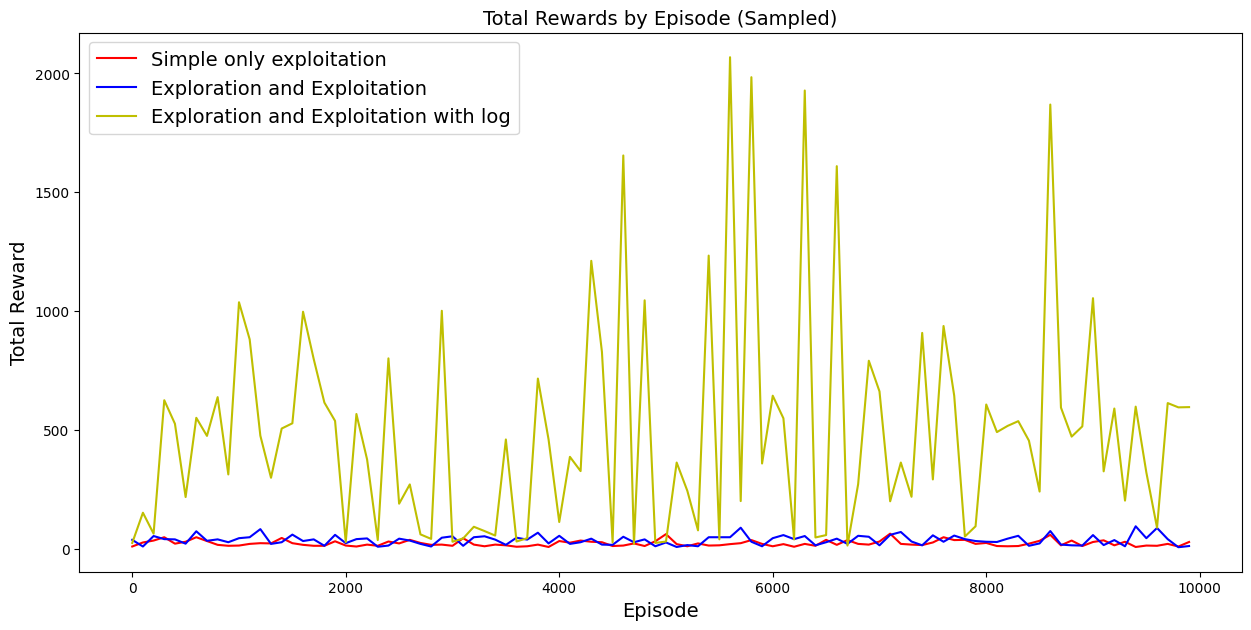

In [ ]:
# Sample the data: Take every 100th episode for example
sample_rate = 100
sampled_episodes = np.arange(0, 10000, sample_rate)
sampled_totals2 = totals2[::sample_rate]  # Assuming totals2 is a list or numpy array
sampled_totals3 = totals3[::sample_rate]
sampled_totals = totals[::sample_rate]

plt.figure(figsize=[15,7])  # Increase figure size
plt.plot(sampled_episodes, sampled_totals3, label='Simple only exploitation', linestyle='-', color = 'r')  # Plot sampled data

plt.plot(sampled_episodes, sampled_totals2, label='Exploration and Exploitation', linestyle='-', color = 'b')  # Plot sampled data
plt.plot(sampled_episodes, sampled_totals, label='Exploration and Exploitation with log', linestyle='-', color = 'y')  # Plot sampled data

# Add title and labels
plt.title('Total Rewards by Episode (Sampled)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.legend()
plt.show()

Show the visualization of the game with Q-learning

In [ ]:
def show_one_episode(n_max_steps=200, seed=42):
    episode = 100001
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    obs, info = env.reset(seed=seed)
    _, _, pole_angle, pole_velocity = obs
    state, done, truncated = discretizer(_,_,pole_angle, pole_velocity), False, False
    total_reward = 0
    while not done:
      frames.append(env.render())
      # Exploitation policy
      action = np.argmax(Q_values[state])  # exploitation policy  greedly selects

      # Exploration policy
      if (np.random.random() < exploration_rate(episode)):
        action = exploration_policy() # exploration policy

      # Set next state and value
      next_state, reward, done, truncated = nstep(action)
      total_reward += reward
      # Fill Q table
      alpha = max(alpha0, min(1.0, 1.0 - math.log10((episode + 1) / 25)))
      Q_values[state][action] *= 1 - alpha
      Q_values[state][action] += alpha*(reward + gamma * np.max(Q_values[next_state]))
      print(f"Action: {action}, Reward: {reward}")
      # Update state
      state = next_state
    env.close()
    print(f"Total reward: {total_reward}")
    return plot_animation(frames)

show_one_episode()

NameError: name 'gym' is not defined